### Importing libraries


In [22]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from sklearn.utils import resample
from sklearn.exceptions import ConvergenceWarning
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)


## Part A: Data Exploration and Baseline Model  [10 points]

In [23]:
#1- load dataset
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
print("Path to dataset files:", path)
df = pd.read_csv(path + "/creditcard.csv")
df.head()

Using Colab cache for faster access to the 'creditcardfraud' dataset.
Path to dataset files: /kaggle/input/creditcardfraud


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


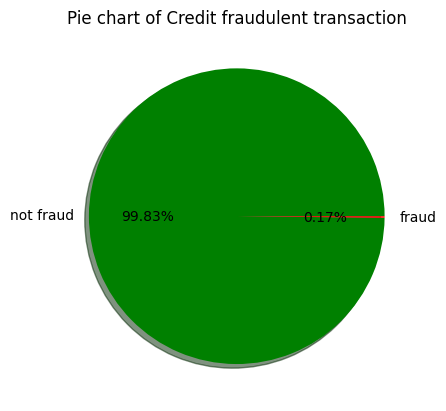

In [24]:
#2
plt.pie(df["Class"].value_counts(), labels=["not fraud","fraud"], autopct="%1.2f%%", shadow=True, colors=['green', 'red'])
plt.title("Pie chart of Credit fraudulent transaction")
plt.show()

From this pie chart we can see that the dataset is highly imbalanced.

In [25]:
#3
X = df.drop(columns="Class", axis=1)
Y = df["Class"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2) # Retaining the original imbalance
print(Y_train.value_counts())
print(Y_test.value_counts())


Class
0    227451
1       394
Name: count, dtype: int64
Class
0    56864
1       98
Name: count, dtype: int64


In [26]:
#Baseline model using logistic regression
base = LogisticRegression(max_iter=500)
base.fit(X_train, Y_train)
base_pred = base.predict(X_test)
print("Test accuracy:",accuracy_score(Y_test, base_pred))


Test accuracy: 0.9992626663389628


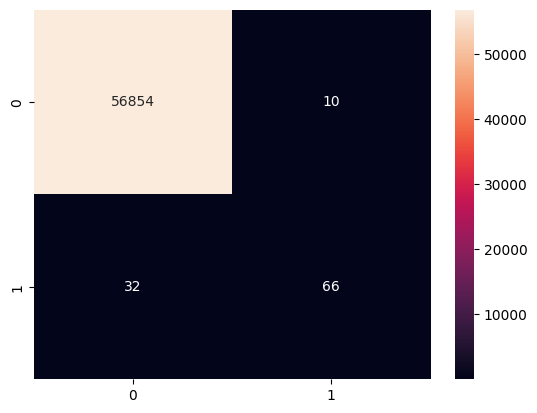


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.87      0.67      0.76        98

    accuracy                           1.00     56962
   macro avg       0.93      0.84      0.88     56962
weighted avg       1.00      1.00      1.00     56962



In [27]:
# evaluate the model
# print("Confusion Matrix:\n", confusion_matrix(Y_test, base_pred))

sns.heatmap(confusion_matrix(Y_test, base_pred), annot=True, fmt="d")
plt.show()
print("\nClassification Report:\n", classification_report(Y_test, base_pred))

From the results of Logistic Regression, I could see that the test Accuracy is almost 100% which is not a reliable metric to consider in this case as we have a imbalanced dataset. So we are not looking at accuracy in this study.

For the fraud class the precision, recall and f1-score are very less compared to not fraud class.

## Part B: Gaussian Mixture Model (GMM) for Synthetic Sampling [35 points]
1. Theoretical Foundation [5]:

* In a markdown cell, explain the fundamental difference between GMM-based
synthetic sampling and simpler methods like SMOTE.
* Discuss why GMM is theoretically better at capturing the underlying data
distribution, especially when the minority class has multiple sub-groups or
complex shapes in the feature space.

The key difference between GMM-based synthetic sampling and simpler methods like SMOTE lies in how they model the minority class distribution:
* SMOTE generates new samples by linearly interpolating between a point and its nearest neighbors, which assumes the data is locally linear and can lead to unrealistic “bridge” samples if the minority class has multiple clusters or complex shapes.

* In contrast, GMM-based sampling first fits a Gaussian Mixture Model to the minority data, explicitly modeling it as a combination of several probabilistic clusters, and then generates synthetic points by sampling from this learned distribution.

This makes GMM better at capturing multi-modal or irregular structures in the feature space, ensuring synthetic samples align more closely with the true underlying data distribution.

GMM is theoretically better because it does not assume the minority class follows a single simple shape, like a line or one cluster. Instead, it models the data as a mixture of multiple Gaussian distributions, where each component can represent a different sub-group of the minority class. This allows GMM to naturally capture complex, multi-modal structures in the feature space.

When the minority data has several clusters or irregular shapes, GMM-based sampling can generate new points that respect these patterns, reducing the risk of producing unrealistic or overlapping samples, which often happens with simpler methods like SMOTE.

In [28]:
minority = X_train[Y_train == 1]
majority = X_train[Y_train == 0]


In [31]:

# Fit GMM for different numbers of components (k)
aic_scores, bic_scores = [], []
n_components_range = range(1, 10)  # test 1–9 components

for k in n_components_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(minority)   # minority = training data of minority class
    bic_scores.append(gmm.bic(minority))
# Choose optimal k (minimum BIC is common)
optimal_k = n_components_range[bic_scores.index(min(bic_scores))]
print("Optimal number of components (k):", optimal_k)

# Fit final GMM
gmm_final = GaussianMixture(n_components=optimal_k, random_state=42)
gmm_final.fit(minority)


Optimal number of components (k): 9


GaussianMixture(n_components=9, random_state=42)

In [30]:
# Number of new synthetic samples needed
n_minority = len(minority)       # original minority size
n_majority = len(majority)       # majority size
n_synthetic = n_majority - n_minority  # balance dataset

# Sample synthetic points from the fitted GMM
synthetic_samples, _ = gmm_final.sample(n_synthetic)

# Convert to DataFrame (keep same feature names if available)
synthetic_df = pd.DataFrame(synthetic_samples, columns=minority.columns)

# Combine with original training data
X_train_GMM = pd.concat([majority, minority, synthetic_df], axis=0).reset_index(drop=True)
Y_train_GMM = pd.Series(
    np.hstack((
        np.zeros(len(majority)),      # label majority
        np.ones(len(minority)),       # label original minority
        np.ones(len(synthetic_df))    # label synthetic minority
    )),
    name="Class"
)

print("Final GMM-balanced dataset shape:")
print(Y_train_GMM.value_counts())


Final GMM-balanced dataset shape:
Class
0.0    227451
1.0    227451
Name: count, dtype: int64


In [14]:
k = 4   # can tune with elbow/silhouette
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(majority)

target_majority_size = len(minority) * 3   # keep it bigger than minority (tunable)

samples_per_cluster = target_majority_size // k
majority_balanced = []

for i in range(k):
    cluster_samples = majority[clusters == i]
    cluster_downsampled = resample(cluster_samples,
                                   replace=False,
                                   n_samples=min(samples_per_cluster, len(cluster_samples)),
                                   random_state=42)
    majority_balanced.append(cluster_downsampled)

majority_resampled = pd.concat(majority_balanced, axis=0).reset_index(drop=True)
print("CBU majority size:", len(majority_resampled))


CBU majority size: 1180


In [15]:
# Fit GMM on minority
k_gmm = 3  # optimal number chosen using BIC/AIC earlier
gmm_final = GaussianMixture(n_components=k_gmm, covariance_type="full", random_state=42)
gmm_final.fit(minority)

# How many synthetic minority samples needed?
n_minority = len(minority)
n_majority_new = len(majority_resampled)
n_synthetic = n_majority_new - n_minority

# Generate synthetic minority
synthetic_samples, _ = gmm_final.sample(n_synthetic)
synthetic_df = pd.DataFrame(synthetic_samples, columns=minority.columns)

# Combine original + synthetic minority
minority_resampled = pd.concat([minority, synthetic_df], axis=0).reset_index(drop=True)
print("GMM minority size:", len(minority_resampled))


GMM minority size: 1180


GaussianMixture(n_components=9, random_state=42)

In [16]:
# Final balanced dataset
X_train_CBU_GMM = pd.concat([majority_resampled, minority_resampled], axis=0).reset_index(drop=True)
Y_train_CBU_GMM = pd.Series(
    np.hstack((
        np.zeros(len(majority_resampled)),   # majority label
        np.ones(len(minority_resampled))     # minority label
    )),
    name="Class"
)

print("Final CBU + GMM dataset shape:")
print(Y_train_CBU_GMM.value_counts())


Final CBU + GMM dataset shape:
Class
0.0    1180
1.0    1180
Name: count, dtype: int64


## Part C: Performance Evaluation and Conclusion [15 points]

In [33]:

# Train model on GMM balanced dataset
log_reg = LogisticRegression(max_iter=500, random_state=42)
log_reg.fit(X_train_GMM, Y_train_GMM)

# Predictions on original, imbalanced test set (from Part A)
y_pred = log_reg.predict(X_test)

# Confusion matrix
print("Confusion Matrix ( GMM):\n", confusion_matrix(Y_test, y_pred))

# Classification report
print("\nClassification Report (GMM):\n", classification_report(Y_test, y_pred))

# Accuracy
print("Accuracy:", accuracy_score(Y_test, y_pred))


Confusion Matrix (CBU + GMM):
 [[55566  1298]
 [    8    90]]

Classification Report (CBU + GMM):
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962

Accuracy: 0.9770724342544153


In [17]:

# Train model on CBU + GMM balanced dataset
log_reg_gmm = LogisticRegression(max_iter=500, random_state=42)
log_reg_gmm.fit(X_train_CBU_GMM, Y_train_CBU_GMM)

# Predictions on original, imbalanced test set (from Part A)
y_pred_gmm = log_reg_gmm.predict(X_test)

# Confusion matrix
print("Confusion Matrix (CBU + GMM):\n", confusion_matrix(Y_test, y_pred_gmm))

# Classification report
print("\nClassification Report (CBU + GMM):\n", classification_report(Y_test, y_pred_gmm))

# Accuracy
print("Accuracy:", accuracy_score(Y_test, y_pred_gmm))


Confusion Matrix (CBU + GMM):
 [[55323  1541]
 [    5    93]]

Classification Report (CBU + GMM):
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.95      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.96      0.55     56962
weighted avg       1.00      0.97      0.98     56962

Accuracy: 0.9728590990484884


### 2. Comparative Analysis [5]:

In [38]:

from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt

# Baseline metrics (from your earlier run)
prec_base = precision_score(Y_test, base_pred, pos_label=1)
rec_base = recall_score(Y_test, base_pred, pos_label=1)
f1_base = f1_score(Y_test, base_pred, pos_label=1)

# GMM metrics
prec_gmm = precision_score(Y_test, y_pred_gmm, pos_label=1)
rec_gmm = recall_score(Y_test, y_pred_gmm, pos_label=1)
f1_gmm = f1_score(Y_test, y_pred_gmm, pos_label=1)

prec = precision_score(Y_test, y_pred, pos_label=1)
rec = recall_score(Y_test, y_pred, pos_label=1)
f1 = f1_score(Y_test, y_pred, pos_label=1)

# Build summary table
results = pd.DataFrame({
    "Model": ["Baseline","GMM", "CBU+GMM" ],
    "Precision": [prec_base, prec, prec_gmm ],
    "Recall": [rec_base, rec, rec_gmm],
    "F1-score": [f1_base, f1, f1_gmm]
})

results


,Model,Precision,Recall,F1-score
0,Baseline,0.868421,0.673469,0.758621
1,GMM,0.064841,0.918367,0.121131
2,CBU+GMM,0.056916,0.948980,0.107390


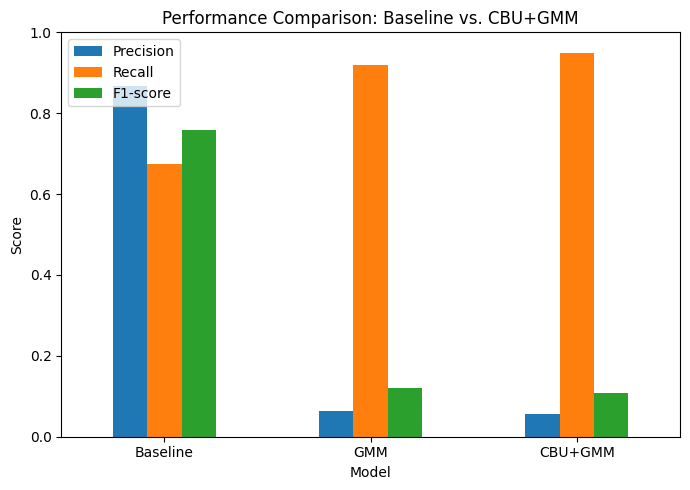

In [41]:
# Plot comparison
results.set_index("Model")[["Precision", "Recall", "F1-score"]].plot(
    kind="bar", figsize=(7,5), rot=0
)
plt.title("Performance Comparison: Baseline vs. CBU+GMM")
plt.ylabel("Score")
plt.ylim(0,1)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()


## 3. Recommendation
Baseline has very high accuracy but very poor recall, meaning it misses most fraud cases.

CBU+GMM improves recall significantly and catches more frauds, though precision drops because of more false alarms.

The impact of GMM oversampling is that the classifier becomes more sensitive to minority patterns, which improves the F1-score and makes fraud detection more practical.